# Get Data From the EIA

Download EIA data, have it be fixed so that it downloads all of the data, instead of a truncated data set.

In [1]:
import requests
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

## Setup

In [2]:
def get_eia_data(series: str, api_key: str, series_name: str = None):
    """
    Gets data from EIA. If the series is monthly, it's shifted one month into the future.

    :param series: The series name on EIA
    :param series_name: A name to give the returned series
    :return: A pandas dataframe with the series
    """

    req = requests.get("http://api.eia.gov/series/?api_key={}&series_id={}".format(api_key, series))
    js = req.json()
    if series_name is None:
        series_name = js['series'][0]['name']
    data = pd.DataFrame(js['series'][0]['data'], columns=['Date', series_name])

    if js['series'][0]['f'] == 'M':
        data['Date'] = pd.to_datetime(data['Date'], format="%Y%m")
        data['Date'] = data['Date'].apply(lambda x: x + relativedelta(months=1))
    else:
        data['Date'] = pd.to_datetime(data['Date'], format="%Y%m%d")

    data.set_index(['Date'], inplace=True)
    return data[series_name]

# get_eia_data("PET.RWTC.D")

## Gasoline

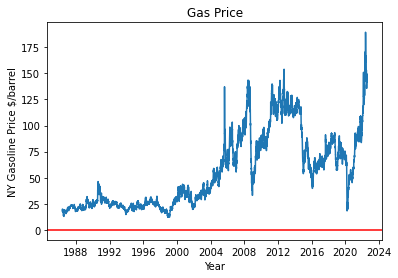

In [7]:
ny_gas = get_eia_data("PET.EER_EPMRU_PF4_Y35NY_DPG.D", "ny_gas")*42
plt.plot(ny_gas)
plt.axhline(y = 0, color = 'red')
plt.title("Gas Price")
plt.xlabel("Year")
plt.ylabel("NY Gasoline Price $/barrel")
plt.savefig("../writeups/graphs/ny_gas.png")
plt.show()

## WTI

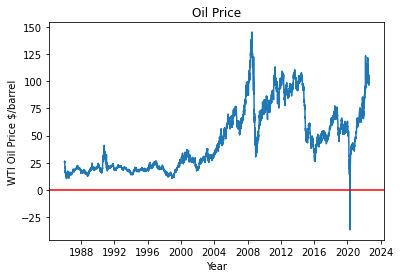

In [11]:
wti = get_eia_data("PET.RWTC.D", "wti")
plt.plot(wti)
plt.axhline(y = 0, color = 'red')
plt.title("Oil Price")
plt.xlabel("Year")
plt.ylabel("WTI Oil Price $/barrel")
plt.savefig("../writeups/graphs/wti.png")
plt.show()

## Crack Spread

1:1 Crack spread. Drop the initial NA values since the series are of different lengths. Also check for stationarity of the series, in which we reject the null, and find that the series is stationary.

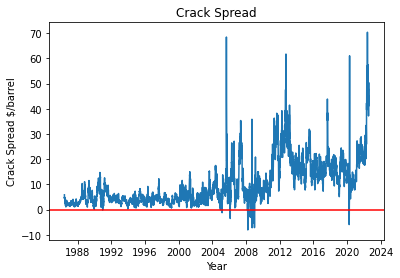

In [9]:
crack = (ny_gas - wti).dropna()
crack.name = "crack"
plt.plot(crack)
plt.axhline(y=0, color = 'red')
plt.title("Crack Spread")
plt.xlabel("Year")
plt.ylabel("Crack Spread $/barrel")
plt.savefig("../writeups/graphs/crack.png")
plt.show()

In [10]:
adfuller(crack)

(-3.6635114551425323,
 0.0046566755356320716,
 33,
 9065,
 {'1%': -3.4310715833098833,
  '5%': -2.8618588932772657,
  '10%': -2.5669397418503186},
 33229.747414769765)

## Predictors

In [23]:
# US oil production
crude_prod = get_eia_data("PET.MCRFPUS1.M", "crude_prod")

In [8]:
# US rotary rigs
crude_rigs = get_eia_data("PET.E_ERTRRO_XR0_NUS_C.M", "crude_rigs")

In [9]:
# US crude oil imports
crude_imports = get_eia_data("PET.WCRIMUS2.W", "crude_imports")

In [10]:
# US crude oil exports
crude_exports = get_eia_data("PET.WCREXUS2.W", "crude_exports")

In [11]:
# US petroleum product imports
products_imports = get_eia_data("PET.WRPIMUS2.W", "products_imports")

In [12]:
# US petroleum product exports
products_exports = get_eia_data("PET.WRPEXUS2.W", "products_exports")

In [13]:
# US net import/export crude
crude_net = get_eia_data("PET.WCRNTUS2.W", "crude_net")

In [14]:
# US net petroleum product import/export
products_net = get_eia_data("PET.WRPNTUS2.W", "products_net")

In [15]:
# US Crude Oil refinery inputs
crude_inputs = get_eia_data("PET.WCRRIUS2.W", "crude_inputs")

In [16]:
# US refinery utilization
ref_utilization = get_eia_data("PET.MOPUEUS2.M", "ref_utilization")

In [17]:
# US refinery capacity
ref_capacity = get_eia_data("PET.MOCLEUS2.M", "ref_capacity")

In [18]:
# US oil reserves, including SPR
crude_reserves = get_eia_data("PET.WCRSTUS1.W", "crude_reserves")

In [19]:
# US gasoline reserves
gas_reserves = get_eia_data("PET.WGTSTUS1.W", "gas_reserves")

In [20]:
# US crude oil supplied, has been 0 since before 2000, so not relevant
# crude_supplied = get_eia_data("PET.MCRUPUS1.M", "crude_supplied")

In [21]:
# US gasoline supplied
gas_supplied = get_eia_data("PET.MG4UP_NUS_1.M", "gas_supplied")

In [24]:
df = pd.concat([crack, ny_gas, wti, crude_prod, crude_rigs, crude_imports, crude_exports, products_imports, products_exports, crude_net, products_net, crude_inputs, ref_utilization, ref_capacity, crude_reserves, gas_reserves, gas_supplied], axis=1)
df

crack   ny_gas     wti  crude_prod  crude_rigs  crude_imports  \
Date                                                                         
1920-02-01     NaN      NaN     NaN     34008.0         NaN            NaN   
1920-03-01     NaN      NaN     NaN     33193.0         NaN            NaN   
1920-04-01     NaN      NaN     NaN     36171.0         NaN            NaN   
1920-05-01     NaN      NaN     NaN     34945.0         NaN            NaN   
1920-06-01     NaN      NaN     NaN     36622.0         NaN            NaN   
...            ...      ...     ...         ...         ...            ...   
2022-07-06  42.196  142.506  100.31         NaN         NaN            NaN   
2022-07-07  46.454  151.074  104.62         NaN         NaN            NaN   
2022-07-08  46.310  153.090  106.78         NaN         NaN         6675.0   
2022-07-11  46.916  153.006  106.09         NaN         NaN            NaN   
2022-07-12  47.966  145.656   97.69         NaN         NaN            NaN   

            crude_exports  products_imports  products_exports  crude_net  \
Date                                                                       
1920-02-01            NaN               NaN               NaN        NaN   
1920-03-01            NaN               NaN               NaN        NaN   
1920-04-01            NaN               NaN               NaN        NaN   
1920-05-01            NaN               NaN               NaN        NaN   
1920-06-01            NaN               NaN               NaN        NaN   
...                   ...               ...               ...        ...   
2022-07-06            NaN               NaN               NaN        NaN   
2022-07-07            NaN               NaN               NaN        NaN   
2022-07-08         3024.0            2199.0            5827.0     3651.0   
2022-07-11            NaN               NaN               NaN        NaN   
2022-07-12            NaN               NaN               NaN        NaN   

            products_net  crude_inputs  ref_utilization  ref_capacity  \
Date                                                                    
1920-02-01           NaN           NaN              NaN           NaN   
1920-03-01           NaN           NaN              NaN           NaN   
1920-04-01           NaN           NaN              NaN           NaN   
1920-05-01           NaN           NaN              NaN           NaN   
1920-06-01           NaN           NaN              NaN           NaN   
...                  ...           ...              ...           ...   
2022-07-06           NaN           NaN              NaN           NaN   
2022-07-07           NaN           NaN              NaN           NaN   
2022-07-08       -3628.0       16640.0              NaN           NaN   
2022-07-11           NaN           NaN              NaN           NaN   
2022-07-12           NaN           NaN              NaN           NaN   

            crude_reserves  gas_reserves  gas_supplied  
Date                                                    
1920-02-01             NaN           NaN           NaN  
1920-03-01             NaN           NaN           NaN  
1920-04-01             NaN           NaN           NaN  
1920-05-01             NaN           NaN           NaN  
1920-06-01             NaN           NaN           NaN  
...                    ...           ...           ...  
2022-07-06             NaN           NaN           NaN  
2022-07-07             NaN           NaN           NaN  
2022-07-08        912201.0      224937.0           NaN  
2022-07-11             NaN           NaN           NaN  
2022-07-12             NaN           NaN           NaN  

[10410 rows x 17 columns]

In [25]:
df.to_csv("merged_data.csv")